In [2]:
import tensorflow as tf
import os


DATA_DIR = 'dataset/car-segmentation'

IMAGE_DIR = os.path.join(DATA_DIR, 'images')
MASK_DIR = os.path.join(DATA_DIR, 'masks')

In [3]:
image_filenames = sorted(os.listdir(IMAGE_DIR))
image_paths = [os.path.join(IMAGE_DIR, fname) for fname in image_filenames]
mask_paths = [os.path.join(MASK_DIR, fname) for fname in image_filenames]


# Create the initial dataset of file path pairs
full_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))


2025-08-22 11:58:59.251052: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-08-22 11:58:59.251094: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-08-22 11:58:59.251097: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
I0000 00:00:1755838739.251505 42632603 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1755838739.251734 42632603 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
DATASET_SIZE = len(image_paths)
TRAIN_SIZE = int(0.8 * DATASET_SIZE) # 80% for training
VAL_SIZE = DATASET_SIZE - TRAIN_SIZE # 20% for validation


full_dataset = full_dataset.shuffle(buffer_size=DATASET_SIZE)

train_dataset = full_dataset.take(TRAIN_SIZE)
val_dataset = full_dataset.skip(TRAIN_SIZE)

print(f"Total examples: {DATASET_SIZE}")
print(f"Training examples: {len(train_dataset)}")
print(f"Validation examples: {len(val_dataset)}")

Total examples: 211
Training examples: 168
Validation examples: 43


In [5]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [6]:
def load_and_preprocess(img_path, label_path):
    # 1. Read and decode the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize pixel values to be between 0 and 1
    img = tf.cast(img, tf.float32) / 255.0

    # 2. Read and decode the label (mask)
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    # Use 'nearest' neighbor resizing for masks to avoid creating new class values
    label = tf.image.resize(label, [IMG_HEIGHT, IMG_WIDTH], method='nearest')

    return img, label

In [7]:
BATCH_SIZE = 32
BUFFER_SIZE = 200 

In [8]:
train_batches = (
    train_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()  # Cache data for faster subsequent epochs
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat() # Repeat the dataset indefinitely
    .prefetch(buffer_size=tf.data.AUTOTUNE) # Prepares the next batches while the current one is processed
)

In [9]:
val_batches = (
    val_dataset
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

2025-08-22 11:59:01.870989: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 11:59:02.871552: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 11:59:03.259856: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 11:59:03.264117: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 11:59:03.265211: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 11:59:03.414785: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 11:59:03.415969: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile



--- Verifying a batch ---
Images batch shape: (32, 128, 128, 3)
Labels batch shape: (32, 128, 128, 1)


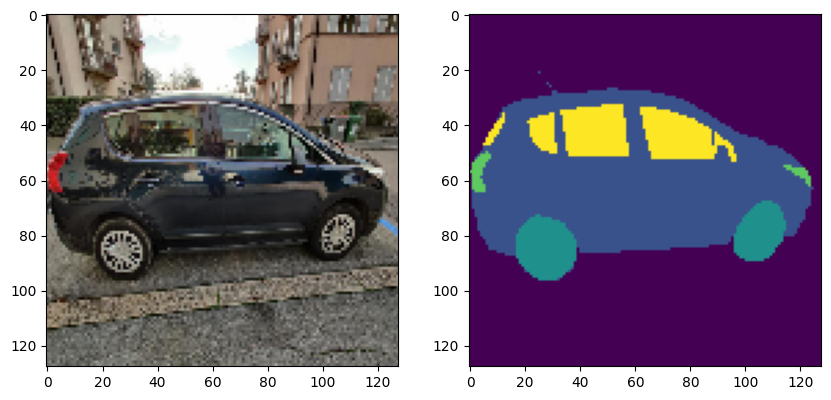

In [10]:
import matplotlib.pyplot as plt
temp_label =None
for images, labels in train_batches.take(1):
    print("\n--- Verifying a batch ---")
    print("Images batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    indx = 0
    
    temp_label = labels[indx]
    axes[0].imshow(images[indx])
    axes[1].imshow(labels[indx],cmap='viridis')
    break
plt.show()

    

In [11]:
import numpy as np
color_value_list = set()
label_numpy = temp_label.numpy()
unique_values = np.unique(label_numpy)
print(unique_values)


for row in range(IMG_WIDTH):
    for col in range(IMG_HEIGHT):
        color_value = label_numpy[row, col][0]
        color_value_list.add(color_value)
        
print(color_value_list) 

[0 1 2 3 4]
{0, 1, 2, 3, 4}


## Build the U-Net Model


In [26]:
import tensorflow as tf
from tensorflow.keras import layers

def build_unet_with_mobilenet(input_shape, num_classes):
    """
    Builds a U-Net model using a pre-trained MobileNetV2 as the encoder.
    (Corrected Version)
    """

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )


    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'out_relu',              # Bottleneck: 4x4
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model (the encoder)
    encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs, name="encoder")
    encoder.trainable = False

    

    #  Build the Decoder Path
    inputs = tf.keras.Input(shape=input_shape)
    skips = encoder(inputs)
    x = skips[-1]
    
    decoder_skips = reversed(skips[:-1])

    for i, skip in enumerate(decoder_skips):
        x = layers.Conv2DTranspose(filters=512 // (2**i), kernel_size=2, strides=2, padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = layers.Conv2D(filters=512 // (2**i), kernel_size=3, padding='same', activation='relu')(x)
        x = layers.Conv2D(filters=512 // (2**i), kernel_size=3, padding='same', activation='relu')(x)

    # It takes the 64x64 feature map and upsamples it to 128x128.
    outputs = layers.Conv2DTranspose(
        filters=num_classes,
        kernel_size=2,
        strides=2,
        padding='same',
        activation='softmax'  # Apply softmax directly here
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [27]:
NUM_CLASSES = 5
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
model = build_unet_with_mobilenet(input_shape, NUM_CLASSES)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 64, 64,   │  2,257,984 │ input_layer_5[0]… │
│ (Functional)        │ 96), (None, 32,   │            │                   │
│                     │ 32, 144), (None,  │            │                   │
│                     │ 16, 16, 192),     │            │                   │
│                     │ (None, 8, 8,      │            │                   │
│                     │ 576), (None, 4,   │            │                   │
│                     │ 4, 1280)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 8, 8, 512) │  2,621,952 │ encoder[0][4]     │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 8, 8,      │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1088)             │            │ encoder[0][3]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 8, 8, 512) │  5,014,016 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_18[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_9  │ (None, 16, 16,    │    524,544 │ conv2d_19[0][0]   │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 448)              │            │ encoder[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 16, 16,    │  1,032,448 │ concatenate_9[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_20[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_10 │ (None, 32, 32,    │    131,200 │ conv2d_21[0][0]   │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 272)              │            │ encoder[0][1]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    313,472 │ concatenate_10[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_22[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_11 │ (None, 64, 64,    │     32,832 │ conv2d_23[0][0]   │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 64, 64,    │          0 │ conv2d_transpose

 Total params: 15,156,357 (57.82 MB)

 Trainable params: 12,898,373 (49.20 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
EPOCHS = 20
STEPS_PER_EPOCH = len(train_dataset) // BATCH_SIZE
print(STEPS_PER_EPOCH)

5


In [30]:

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6
)

history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_batches,
    callbacks=[lr_scheduler]
)

Epoch 1/20


2025-08-22 12:04:15.488711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4123 - loss: 1.4504

2025-08-22 12:04:21.877333: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 670ms/step - accuracy: 0.4323 - loss: 1.4201 - val_accuracy: 0.6215 - val_loss: 1.0131 - learning_rate: 0.0010
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5743 - loss: 1.0424

2025-08-22 12:04:24.871851: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step - accuracy: 0.5791 - loss: 1.0327 - val_accuracy: 0.7265 - val_loss: 0.8380 - learning_rate: 0.0010
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 263ms/step - accuracy: 0.7115 - loss: 0.8347 - val_accuracy: 0.7557 - val_loss: 0.6777 - learning_rate: 0.0010
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7708 - loss: 0.6454

2025-08-22 12:04:27.144539: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.7720 - loss: 0.6433 - val_accuracy: 0.8185 - val_loss: 0.5589 - learning_rate: 0.0010
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8300 - loss: 0.5195

2025-08-22 12:04:28.296596: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.8297 - loss: 0.5197 - val_accuracy: 0.8504 - val_loss: 0.4498 - learning_rate: 0.0010
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.8443 - loss: 0.4526 - val_accuracy: 0.8582 - val_loss: 0.3963 - learning_rate: 0.0010
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8564 - loss: 0.4060

2025-08-22 12:04:30.424937: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:30.432895: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:30.458832: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:30.491668: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.8569 - loss: 0.4043 - val_accuracy: 0.8693 - val_loss: 0.3624 - learning_rate: 0.0010
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8686 - loss: 0.3742

2025-08-22 12:04:31.584980: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:31.591731: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:31.600298: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 277ms/step - accuracy: 0.8688 - loss: 0.3729 - val_accuracy: 0.8756 - val_loss: 0.3548 - learning_rate: 0.0010
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8870 - loss: 0.3253

2025-08-22 12:04:32.754100: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:32.769230: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.8862 - loss: 0.3272 - val_accuracy: 0.8921 - val_loss: 0.2926 - learning_rate: 0.0010
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.8936 - loss: 0.2866 - val_accuracy: 0.8916 - val_loss: 0.2873 - learning_rate: 0.0010
Epoch 11/20


2025-08-22 12:04:33.805347: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:33.814229: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8915 - loss: 0.2803

2025-08-22 12:04:34.696820: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:34.698487: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.8927 - loss: 0.2771 - val_accuracy: 0.9094 - val_loss: 0.2302 - learning_rate: 0.0010
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 264ms/step - accuracy: 0.8986 - loss: 0.2524 - val_accuracy: 0.9024 - val_loss: 0.2397 - learning_rate: 0.0010
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9058 - loss: 0.2335

2025-08-22 12:04:36.880154: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.9054 - loss: 0.2344 - val_accuracy: 0.9139 - val_loss: 0.2182 - learning_rate: 0.0010
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9091 - loss: 0.2261

2025-08-22 12:04:37.979122: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:38.043367: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:38.057778: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.9092 - loss: 0.2252 - val_accuracy: 0.9092 - val_loss: 0.2290 - learning_rate: 0.0010
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9162 - loss: 0.2143

2025-08-22 12:04:39.193077: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.9160 - loss: 0.2153 - val_accuracy: 0.9244 - val_loss: 0.1957 - learning_rate: 0.0010
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9269 - loss: 0.1889

2025-08-22 12:04:40.273659: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:40.275034: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:40.310505: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:40.341899: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.9266 - loss: 0.1896 - val_accuracy: 0.9363 - val_loss: 0.1661 - learning_rate: 0.0010
Epoch 17/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9338 - loss: 0.1738

2025-08-22 12:04:41.354496: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:41.358072: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.9338 - loss: 0.1735 - val_accuracy: 0.9254 - val_loss: 0.1980 - learning_rate: 0.0010
Epoch 18/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9395 - loss: 0.1589

2025-08-22 12:04:42.497231: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:42.510965: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.9397 - loss: 0.1583 - val_accuracy: 0.9394 - val_loss: 0.1642 - learning_rate: 0.0010
Epoch 19/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9427 - loss: 0.1509

2025-08-22 12:04:43.649128: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:43.655430: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:43.731703: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 0.9428 - loss: 0.1509 - val_accuracy: 0.9478 - val_loss: 0.1402 - learning_rate: 0.0010
Epoch 20/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9411 - loss: 0.1531

2025-08-22 12:04:44.875396: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:44.894931: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - accuracy: 0.9414 - loss: 0.1525 - val_accuracy: 0.9393 - val_loss: 0.1600 - learning_rate: 0.0010


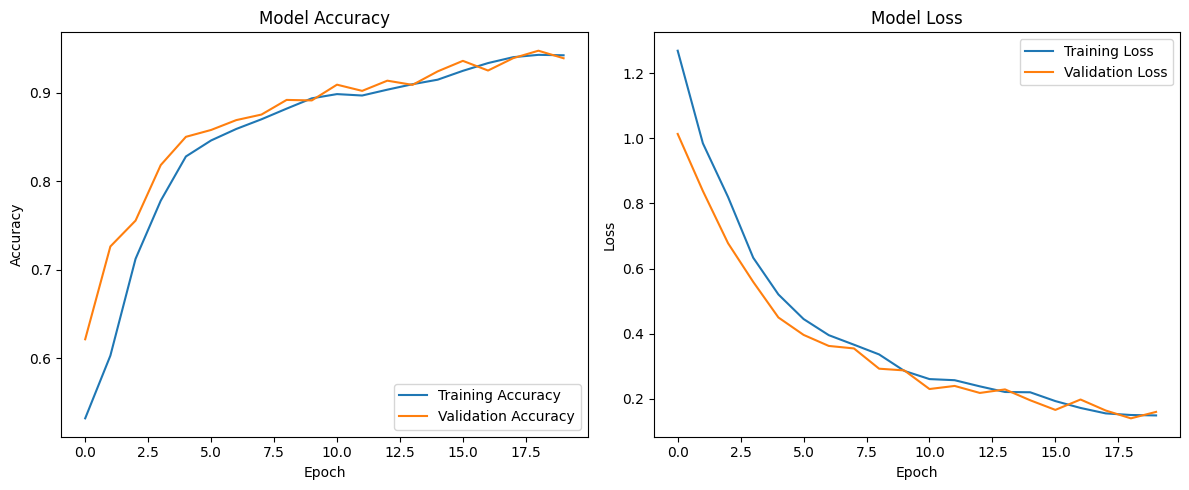

In [31]:
import matplotlib.pyplot as plt


has_validation_data = 'val_loss' in history.history


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if has_validation_data:
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if has_validation_data:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [32]:
print("Evaluating model on the test set...")
loss, accuracy = model.evaluate(val_batches)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating model on the test set...


2025-08-22 12:04:52.714246: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-08-22 12:04:52.734577: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9485 - loss: 0.1372 

Test Loss: 0.1378
Test Accuracy: 0.9484


### Model Saving and Prediction

In [33]:
model.save('models/car_segmentation_unet.keras')

In [34]:
loaded_model = tf.keras.models.load_model('models/car_segmentation_unet.keras')

In [35]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [36]:
def model_predict(image_path, model):
    # This must be IDENTICAL to your training preprocessing
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img_normalized = tf.cast(img, tf.float32) / 255.0
    

    img_batch = tf.expand_dims(img_normalized, axis=0)

    # Predict
    predicted_masks = model.predict(img_batch)
    return predicted_masks , img
    

In [37]:
def predict_and_visualize(image_path, model):

   
    predicted_masks,img = model_predict(image_path, model)

    # The output is (1, H, W, num_classes).
    #  We take the argmax along the
    # class axis to get the final mask (1, H, W).
    pred_mask = tf.argmax(predicted_masks, axis=-1)
    
    # Remove the batch dimension to get a displayable image (H, W)
    pred_mask = pred_mask[0]
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    # Display the original, un-normalized image
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask)
    plt.axis('off')
    
    plt.show()

2025-08-22 12:04:57.515395: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


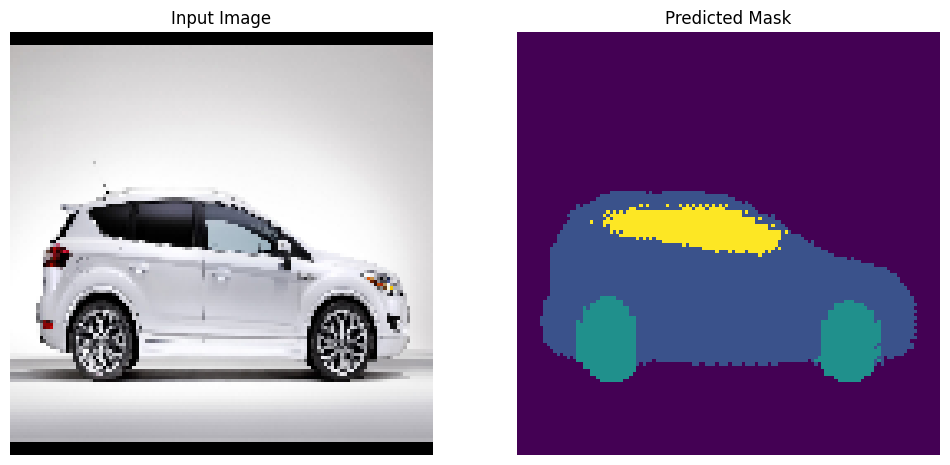

In [38]:
test_path = "dataset/car-segmentation/images/2009-Ford-Kuga-Show-Car-Side-1280x960.png"
#test_path = "dataset/car-segmentation/images/003.png"

predict_and_visualize(test_path, loaded_model)

In [39]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def predict_and_show_all_masks(image_path, model, class_encodings):
    """
    Loads an image, gets a prediction, and displays the probability
    mask for every individual class.
    """
    predicted_masks,img = model_predict(image_path, model)

    
    # --- 3. Visualize the Input and All Masks ---
    num_classes = model.output_shape[-1]
    
    # Create a figure to display the results
    # We need 1 spot for the input image + num_classes spots for the masks
    plt.figure(figsize=(15, 4 * (num_classes // 3 + 1)))
    
    # Plot the input image
    plt.subplot(2, 3, 1)
    plt.title("Input Image")
    plt.imshow(tf.keras.utils.array_to_img(img))
    plt.axis('off')
    
    # Loop through each class and plot its probability mask
    for i in range(num_classes):
        # Extract the mask for the i-th class
        class_mask = predicted_masks[0, :, :, i]
        
        # Get the class name from our encodings dictionary
        # JSON keys are strings, so we convert the index `i` to a string
        class_name = class_encodings.get(str(i), f"Class {i}")
        
        plt.subplot(2, 3, i + 2)
        plt.title(f"Mask: {class_name}")
        # Display the mask as a heatmap. 'viridis' is a good colormap for this.
        plt.imshow(class_mask, cmap='viridis') 
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


2025-08-22 12:04:59.896875: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


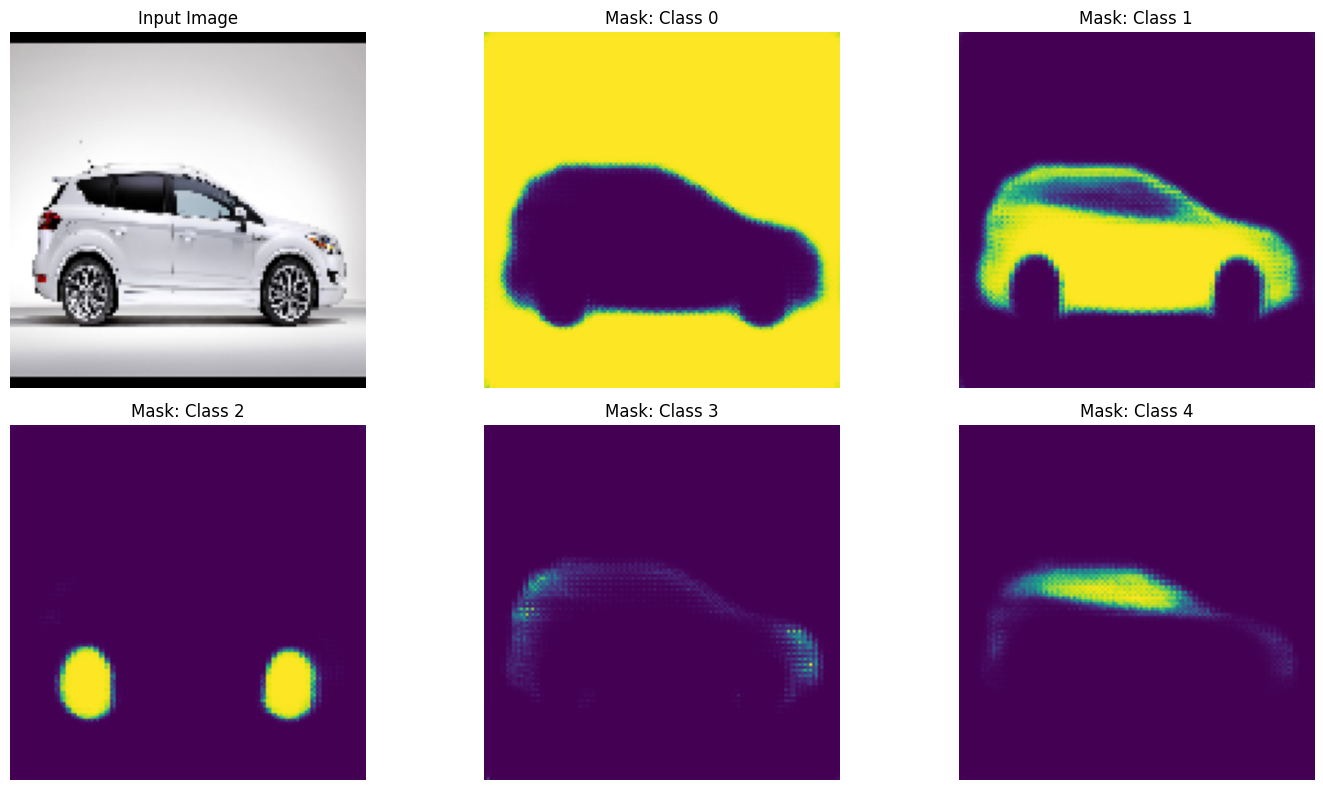

In [40]:
generic_encodings = {str(i): f"Class {i}" for i in range(NUM_CLASSES)}

predict_and_show_all_masks(test_path, loaded_model, generic_encodings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


2025-08-22 12:05:00.230628: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile


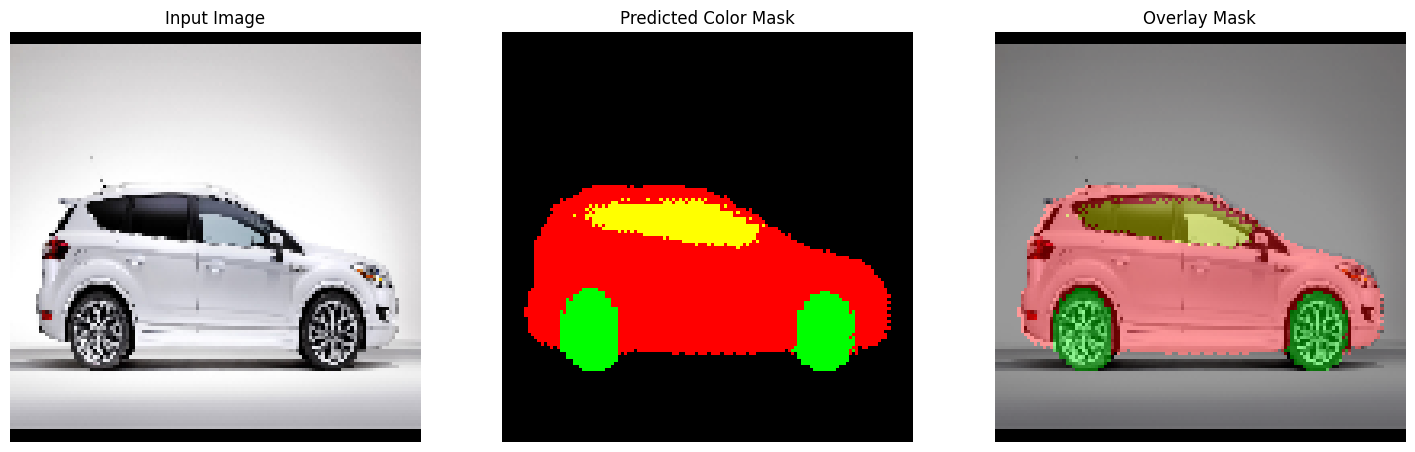

In [41]:
import numpy as np
import cv2 

# 1. Define a color for each of your 5 classes (0 to 4)
COLOR_MAP = np.array([
    [0, 0, 0],       # Class 0: Black (e.g., background)
    [255, 0, 0],     # Class 1: Red
    [0, 255, 0],     # Class 2: Green
    [0, 0, 255],     # Class 3: Blue
    [255, 255, 0]    # Class 4: Yellow
], dtype=np.uint8)

def mask_to_rgb(mask, color_map):
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_idx, color in enumerate(color_map):
        rgb_mask[mask == class_idx] = color
    return rgb_mask


def predict_and_visualize_color(image_path, model, color_map):
    predicted_masks, img = model_predict(image_path, model)
    pred_mask = tf.argmax(predicted_masks, axis=-1)[0].numpy()
    
    # Convert mask to color
    color_mask = mask_to_rgb(pred_mask, color_map)
    
    # Convert original image tensor for display
    input_image_numpy = tf.keras.utils.img_to_array(img, dtype=np.uint8)
    
    # Blend the input image and the color mask for an overlay effect
    overlay = cv2.addWeighted(input_image_numpy, 0.6, color_mask, 0.4, 0)
    
    # Display the results
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_image_numpy)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Predicted Color Mask")
    plt.imshow(color_mask)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Overlay Mask")
    plt.imshow(overlay)
    plt.axis('off')
    
    plt.show()


test_path = "dataset/car-segmentation/images/2009-Ford-Kuga-Show-Car-Side-1280x960.png"
predict_and_visualize_color(test_path, loaded_model, COLOR_MAP)